In [2]:
#load dataset

import pandas as pd

file_path = '/Users/abubakaral-faki/Documents/Data Project/MPV1/data/interim/v3_accepted_loans.csv'

accepted_loans_eda = pd.read_csv(file_path)

/var/folders/yj/v54tzbn14gb70ts6s0j5s3xm0000gn/T/ipykernel_13035/2454467369.py:7: DtypeWarning: Columns (17,47,57,116,127,128,129,132,133,134,137,143,144,145,153) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_loans_eda = pd.read_csv(file_path)


## Analysing correlations between variables

In [9]:
numeric_columns = accepted_loans_eda.select_dtypes(include = ['float64', 'int64']).columns

relevant_columns = ['loan_amnt', 'emp_length', 'funded_amnt', 'int_rate', 'installment', 'annual_inc',
    'dti', 'fico_range_low', 'fico_range_high', 'revol_util', 'bc_util',
    'all_util', 'acc_open_past_24mths', 'delinq_2yrs', 'inq_last_6mths'   
]

# Ensure relevant columns exist in the dataset
filtered_columns = [col for col in relevant_columns if col in numeric_columns]

# Define correlation matrix
correlation_matrix = accepted_loans_eda[filtered_columns].corr()

In [14]:
accepted_loans_eda['fico_range_low'].head()

0    675.0
1    715.0
2    695.0
3    785.0
4    695.0
Name: fico_range_low, dtype: float64

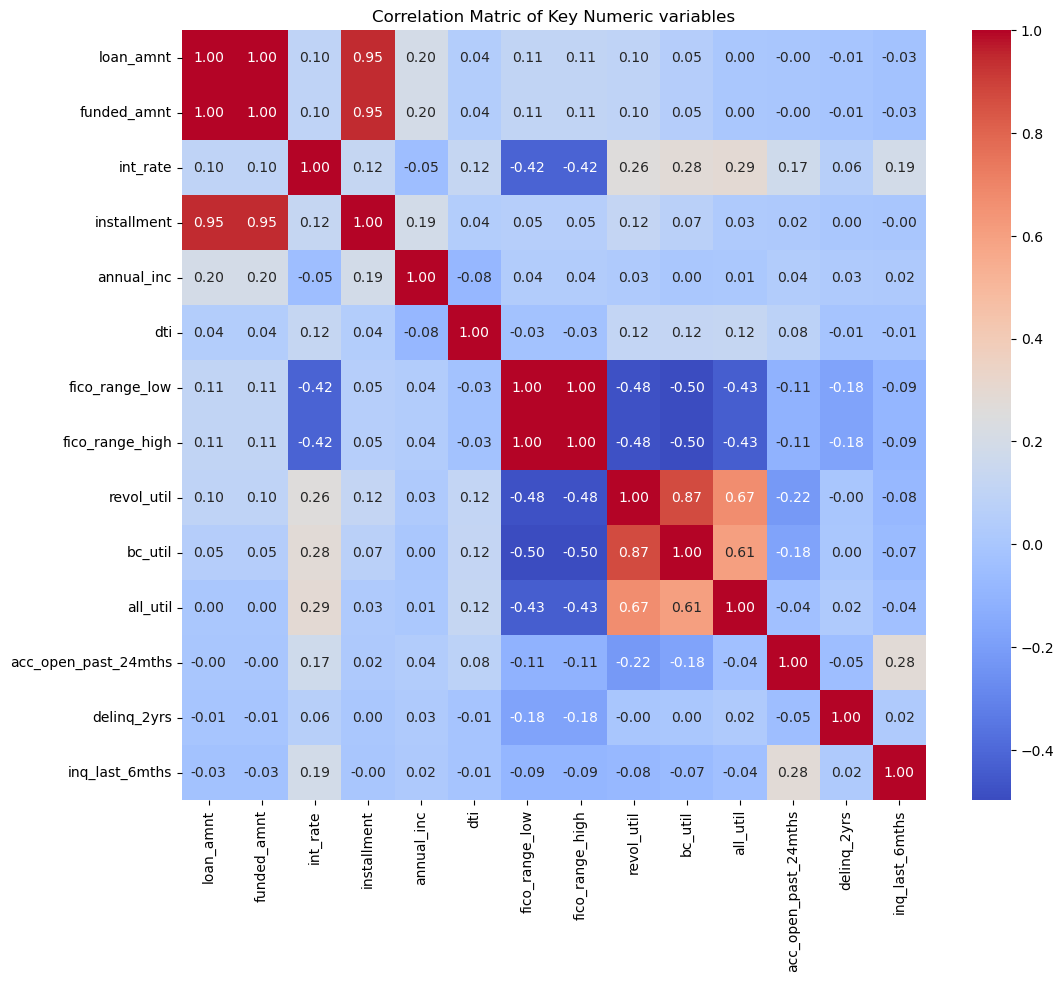

In [10]:
# Visualize Correlation Matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12, 10))
sns.heatmap(correlation_matrix, annot = True, fmt = ".2f", cmap = "coolwarm", cbar = True)
plt.title("Correlation Matrix of Key Numeric variables")
plt.show()

## Obeservations

LendingCLub seems to have a good underwriting process

### Debt-to-income ratio (dti)
dti has weak correlation with most variables.

LendingCLub seems not prioritize debt-to-income ratio (d.t.i) of a borrower as d.t.i doesn't influence key metrics like loan interest rate, loan amount (loan_amnt) or FICO scores.

#### Potential Concern

If dti is not adequately weighted during the underwriting process then we may have cases where borrowers with high debt to income ratio get approved for loans they may struggle to service in the future.

Borrowers who get approved for loans with a potential for their income increasing can increase likelihood of a borrower defaulting on their loan


#### Recommendation
It can be worthwhile to consider the weighting dti in LendingClubs underwriting process to identify high risk borrowers because in our current economic climates, valuations of assets such as homes, cars, businesses are typically well above a persons income and these assets tend to increase in price faster than incomes.



In [48]:
import hvplot.pandas

# Calculate the percentages of each loan status
loan_status_percentages = (accepted_loans_eda['loan_status'].value_counts(normalize=True) * 100)

# Plot the percentages
loan_status_percentages.hvplot.bar(
    title="Loan Status Percentages", 
    xlabel='Loan Status', 
    ylabel='Percentage (%)', 
    width=1000, 
    height=600,
    rot=45  # Rotate x-axis labels for better readability, if needed
)


:Bars   [loan_status]   (proportion)